In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from enterprise.signals.utils import ConditionalGP
from enterprise import constants as const
from h5pulsar import FilePulsar
import la_forge.core as co
import models

In [8]:
psrname = 'J1939+2134'
# get la_forge core
c = co.Core(corepath='./core.h5')
# get pulsar object
psr_path = f'./{psrname}.hdf5'
psr = FilePulsar(psr_path)

In [11]:
pta = models.model_singlepsr_noise(psr, Tspan=952746385.6296968,
                                   # timing - set svd false for GPs
                                   tm_svd=False,
                                   # white noise - set gp_ecorr True for GPs
                                   tnequad=True, inc_ecorr=True, gp_ecorr=True,
                                   #efeq_groups=efeq_groups_by_PTA, ecorr_groups=ecorr_groups_by_PTA,
                                   log_equad_min=-10, log_equad_max=-4,
                                   # DM
                                   dm_var=True, dm_type='gp',
                                   dmgp_kernel='diag', dm_psd='powerlaw',
                                   dm_Nfreqs=30,
                                   # solar wind
                                   dm_sw_deter=False,
                                   # dm dip
                                   dm_expdip=False, dm_expdip_basename='exp',
                                   dm_expdip_tau_min=np.log10(5), dm_expdip_tau_max=np.log10(500), 
                                   # red noise
                                   log_A_min=-20, log_A_max=-11)
for signal in pta.signals:
    if pta.signals[signal].signal_type == 'basis':
        pta.signals[signal].basis_combine=False
gp = ConditionalGP(pta)
mlv_params = {p:c(p)[c.map_idx] for p in c.params}
mlv_GPs = gp.sample_processes(mlv_params, n=1)[0]
correction = np.sum([mlv_GPs[sn] for sn in mlv_GPs if not 'ecorr' in sn], axis=0)

In [12]:
for p in c.params:
    if 'ecorr' in p:
        print(f'{p}: {c.get_map_param(p)}')

J1939+2134_L-wide_ASP_log10_ecorr: -6.470977892964429
J1939+2134_L-wide_PUPPI_log10_ecorr: -6.829059224346202
J1939+2134_Rcvr1_2_GASP_log10_ecorr: -6.435548740012303
J1939+2134_Rcvr1_2_GUPPI_log10_ecorr: -6.520375319139569
J1939+2134_Rcvr_800_GASP_log10_ecorr: -6.102863284685823
J1939+2134_Rcvr_800_GUPPI_log10_ecorr: -6.187777200661973
J1939+2134_S-wide_ASP_log10_ecorr: -6.746394473171394
J1939+2134_S-wide_PUPPI_log10_ecorr: -6.722441367075539


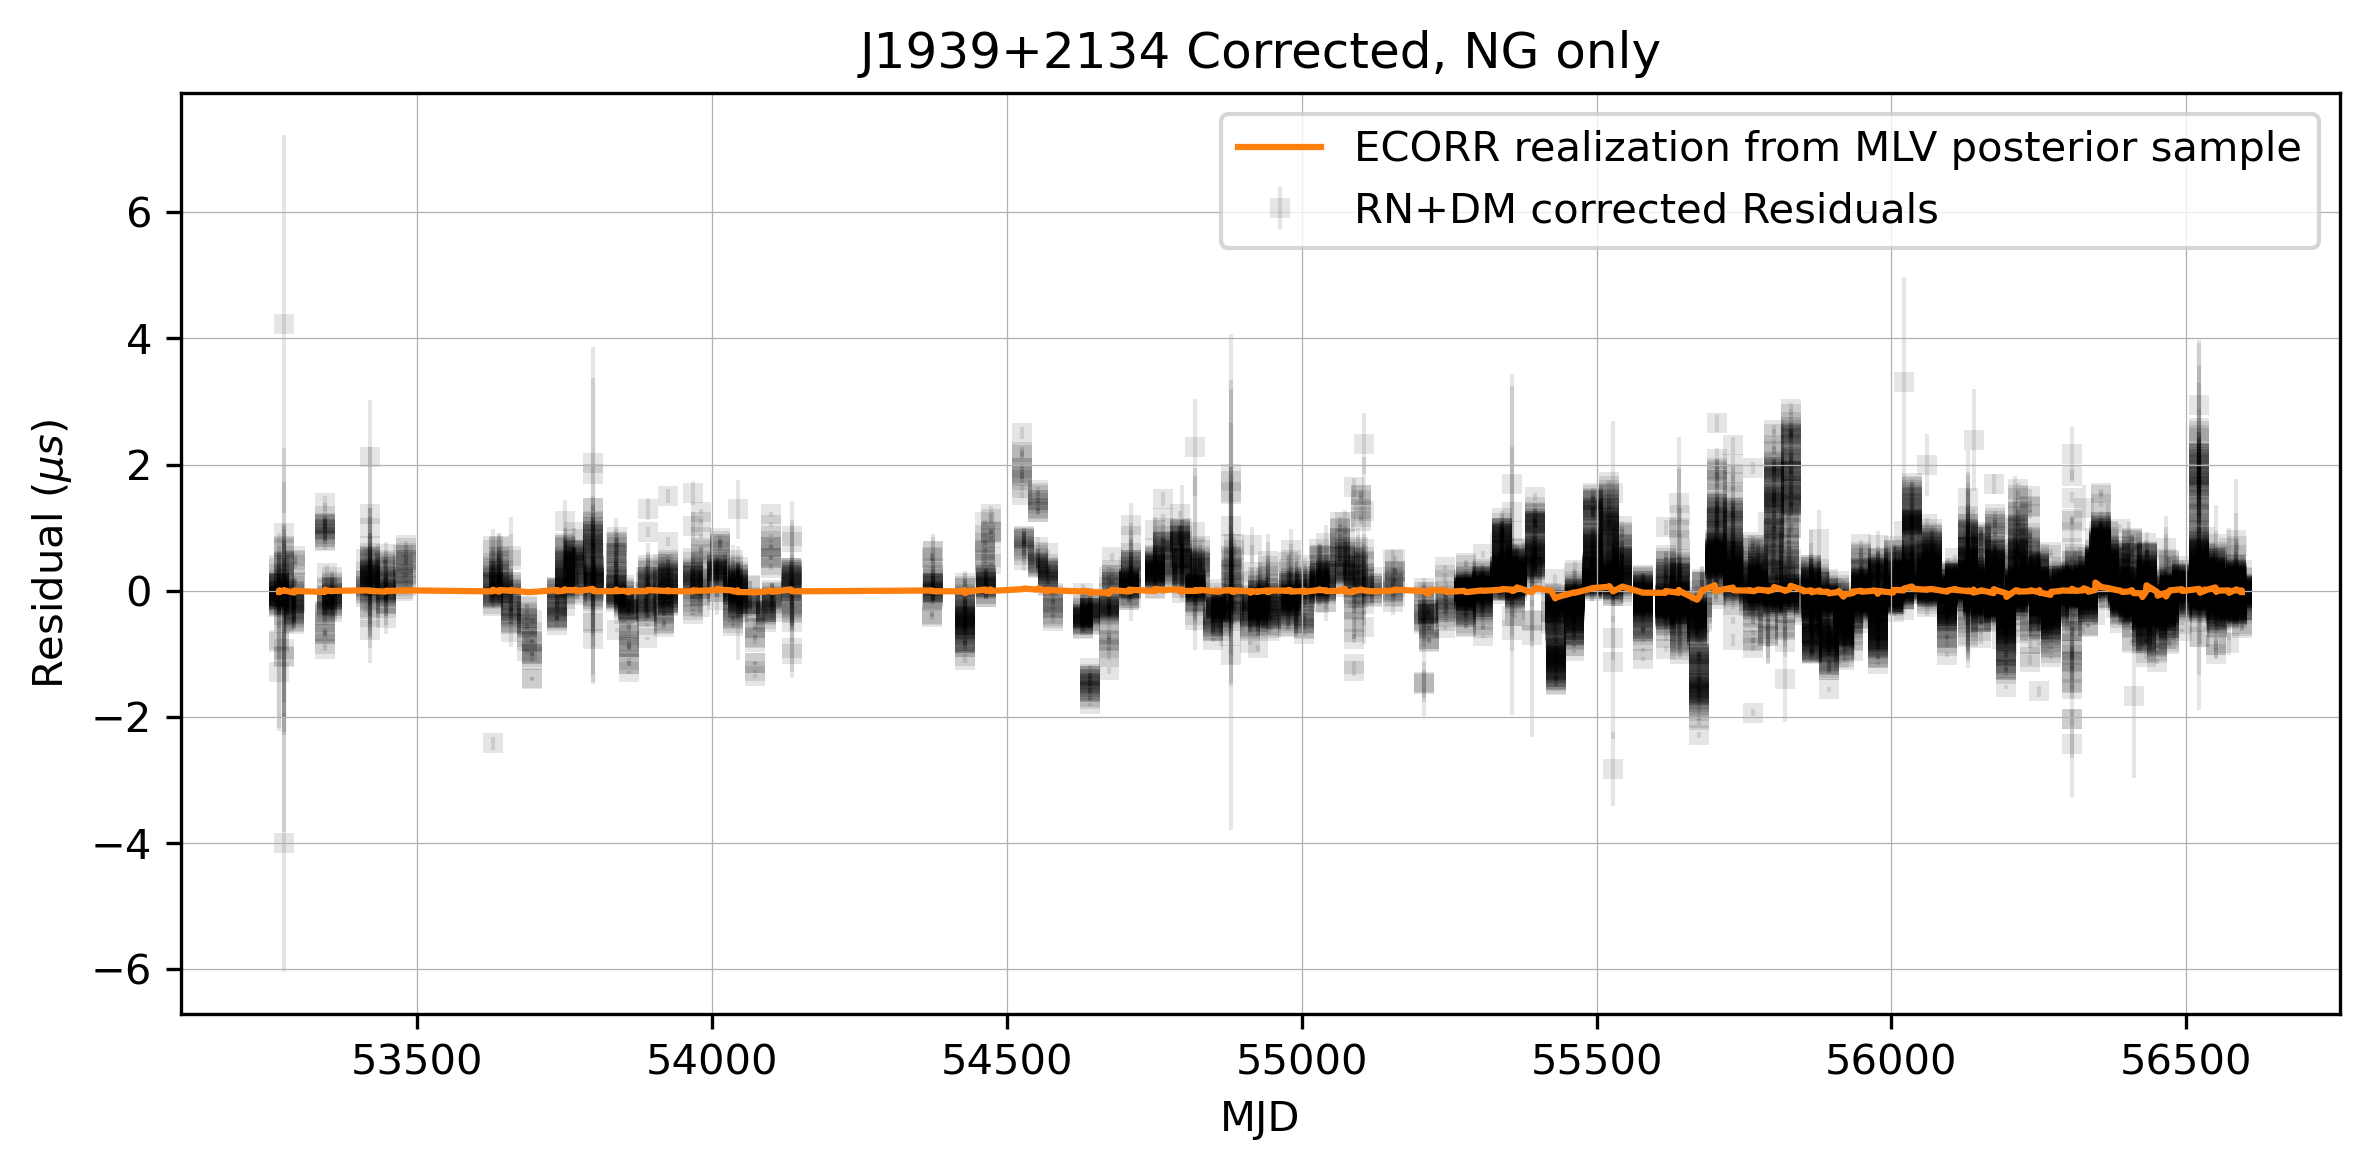

In [16]:
fig, ax = plt.subplots(figsize=(8,4))
nu_min = np.min(psr.freqs)
nu_max = np.max(psr.freqs)
#mean_GPs = gp.get_mean_processes(mlv_params)
if isinstance(correction, np.ndarray):
    resids = psr.residuals - correction
else:
    resids = psr.residuals
for marker, pta in zip(['s'], ['NANOGrav']):
    if pta in psr.flags['pta']:
        mask = (psr.flags['pta'] == pta)*(psr.flags['group'] != 'kaspi23')*(psr.flags['group'] != 'kaspi14')
        ax.errorbar(psr.toas[mask]/const.day, resids[mask]*1e6, yerr=psr.toaerrs[mask]*1e6,
                    fmt=f'{marker}k', ms=5, marker=None, mew=0, alpha=0.1, lw=1, zorder=0,
                    label='RN+DM corrected Residuals')
        ax.plot(psr.toas[mask]/const.day, 1e6*mlv_GPs[f'{psrname}_basis_ecorr'][mask],
                'C1', label='ECORR realization from MLV posterior sample')
ax.set_xlabel("MJD")
ax.set_ylabel(r"Residual ($\mu s$)")
ax.grid(linewidth=0.3)
if isinstance(correction, np.ndarray):
    ax.set_title(psr.name+' Corrected, NG only')
else:
    ax.set_title(psr.name)
ax.legend()
fig.tight_layout()

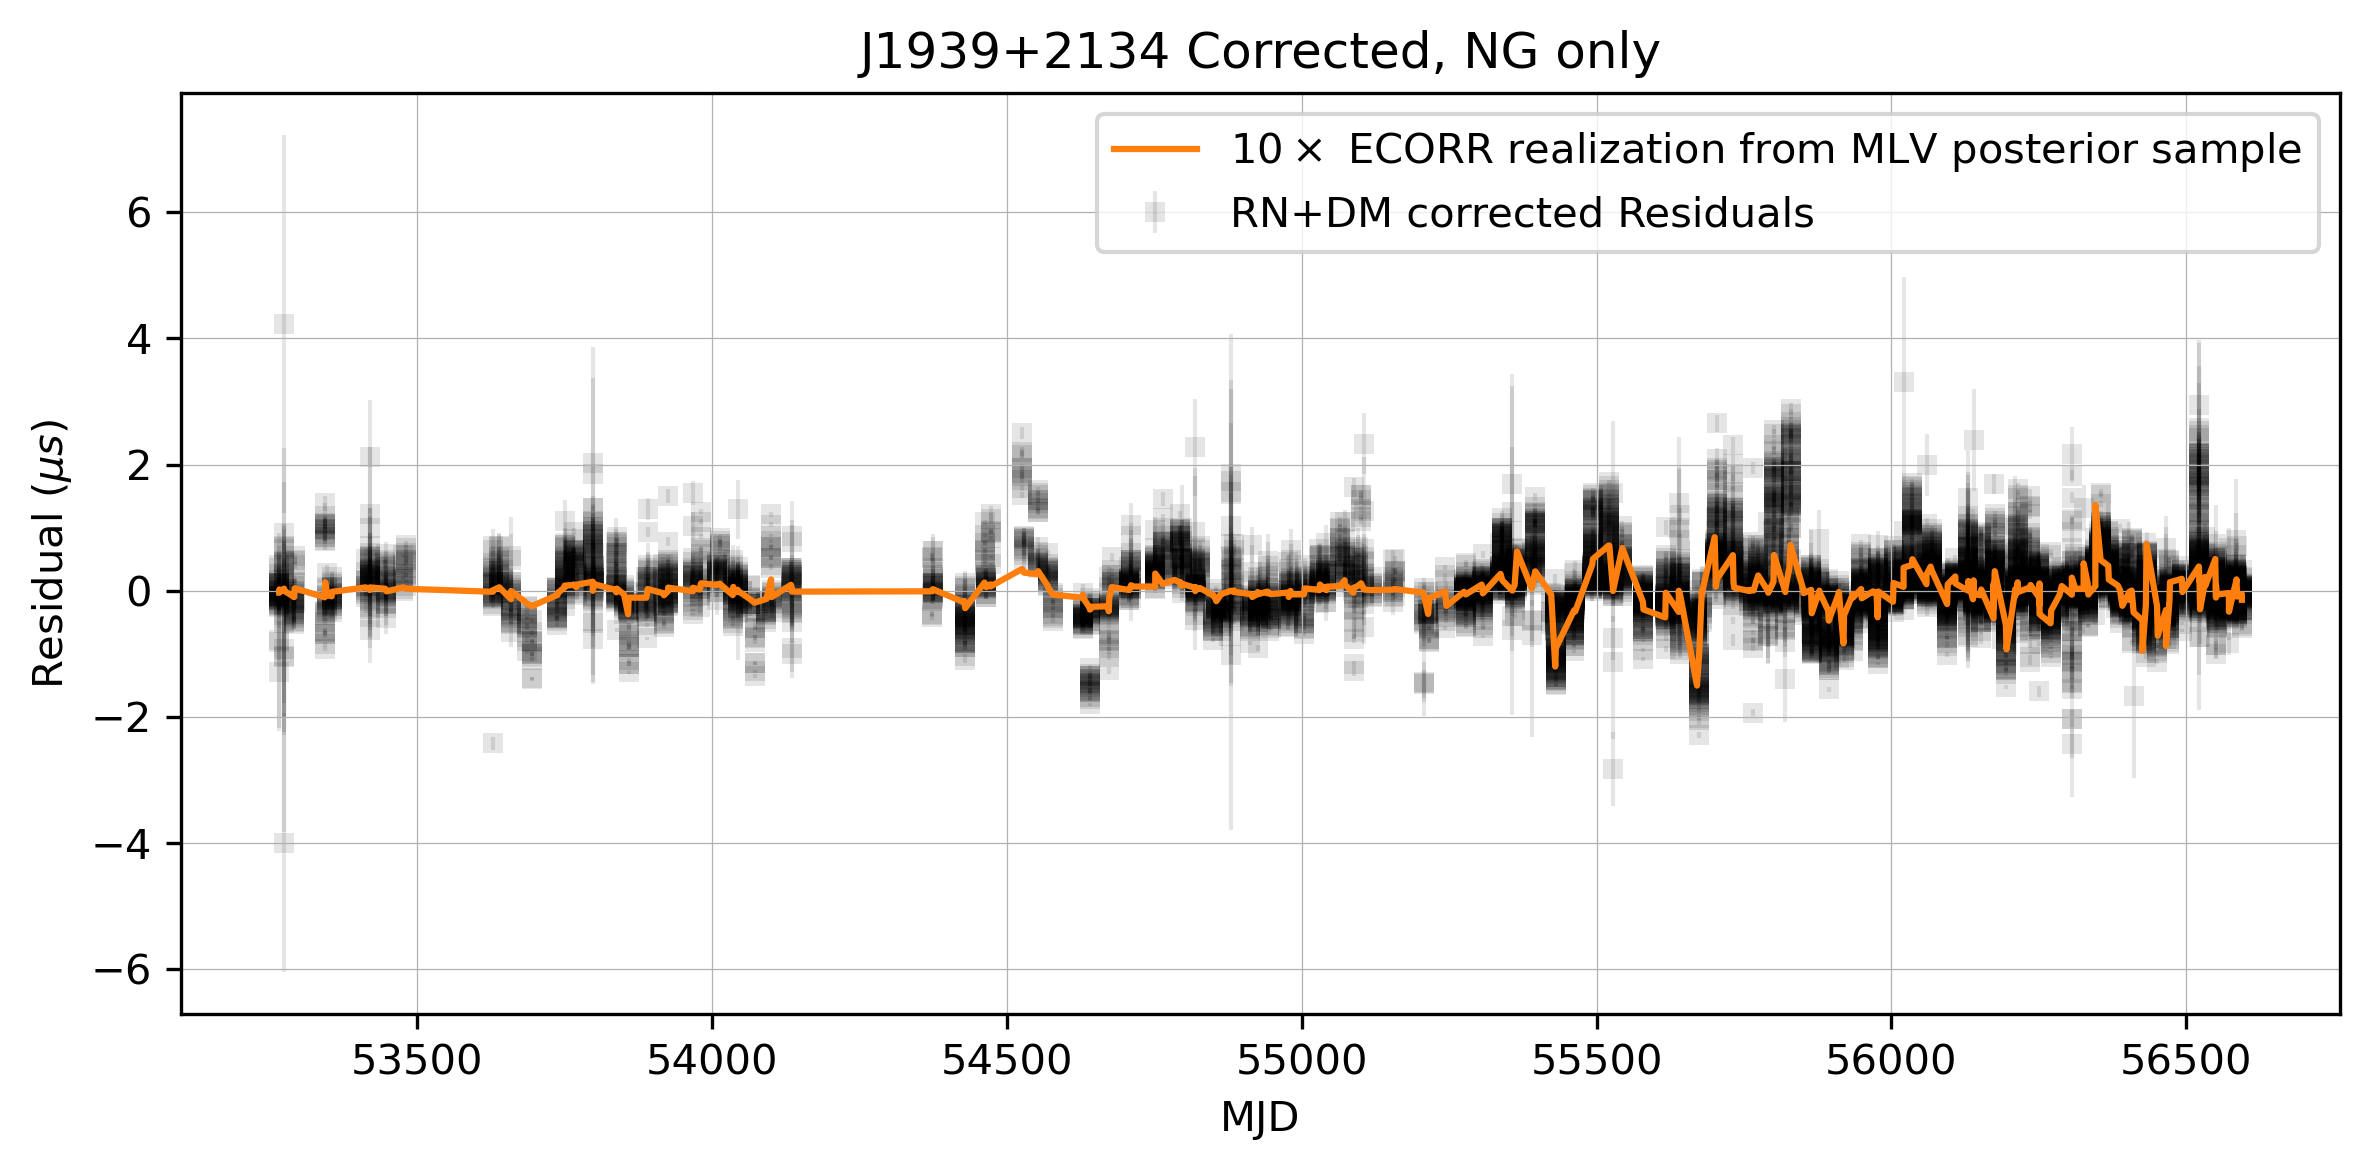

In [17]:
fig, ax = plt.subplots(figsize=(8,4))
nu_min = np.min(psr.freqs)
nu_max = np.max(psr.freqs)
mean_GPs = gp.get_mean_processes(mlv_params)
if isinstance(correction, np.ndarray):
    resids = psr.residuals - correction
else:
    resids = psr.residuals
for marker, pta in zip(['s'], ['NANOGrav']):
    if pta in psr.flags['pta']:
        mask = (psr.flags['pta'] == pta)*(psr.flags['group'] != 'kaspi23')*(psr.flags['group'] != 'kaspi14')
        ax.errorbar(psr.toas[mask]/const.day, resids[mask]*1e6, yerr=psr.toaerrs[mask]*1e6,
                    fmt=f'{marker}k', ms=5, marker=None, mew=0, alpha=0.1, lw=1, zorder=0,
                    label='RN+DM corrected Residuals')
        ax.plot(psr.toas[mask]/const.day, 1e7*mean_GPs[f'{psrname}_basis_ecorr'][mask],
                'C1', label=r'$10 \times$ ECORR realization from MLV posterior sample')
ax.set_xlabel("MJD")
ax.set_ylabel(r"Residual ($\mu s$)")
ax.grid(linewidth=0.3)
if isinstance(correction, np.ndarray):
    ax.set_title(psr.name+' Corrected, NG only')
else:
    ax.set_title(psr.name)
ax.legend()
fig.tight_layout()